### Sediment Porosity Profiles

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/fitur_clean/light.csv')

In [3]:
# Convert date column to datetime
df['depth_reading_time'] = pd.to_datetime(df['depth_reading_time'])

# Select only numeric columns for correlation analysis
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Calculate correlation matrix
corr_matrix = df[numeric_cols].corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

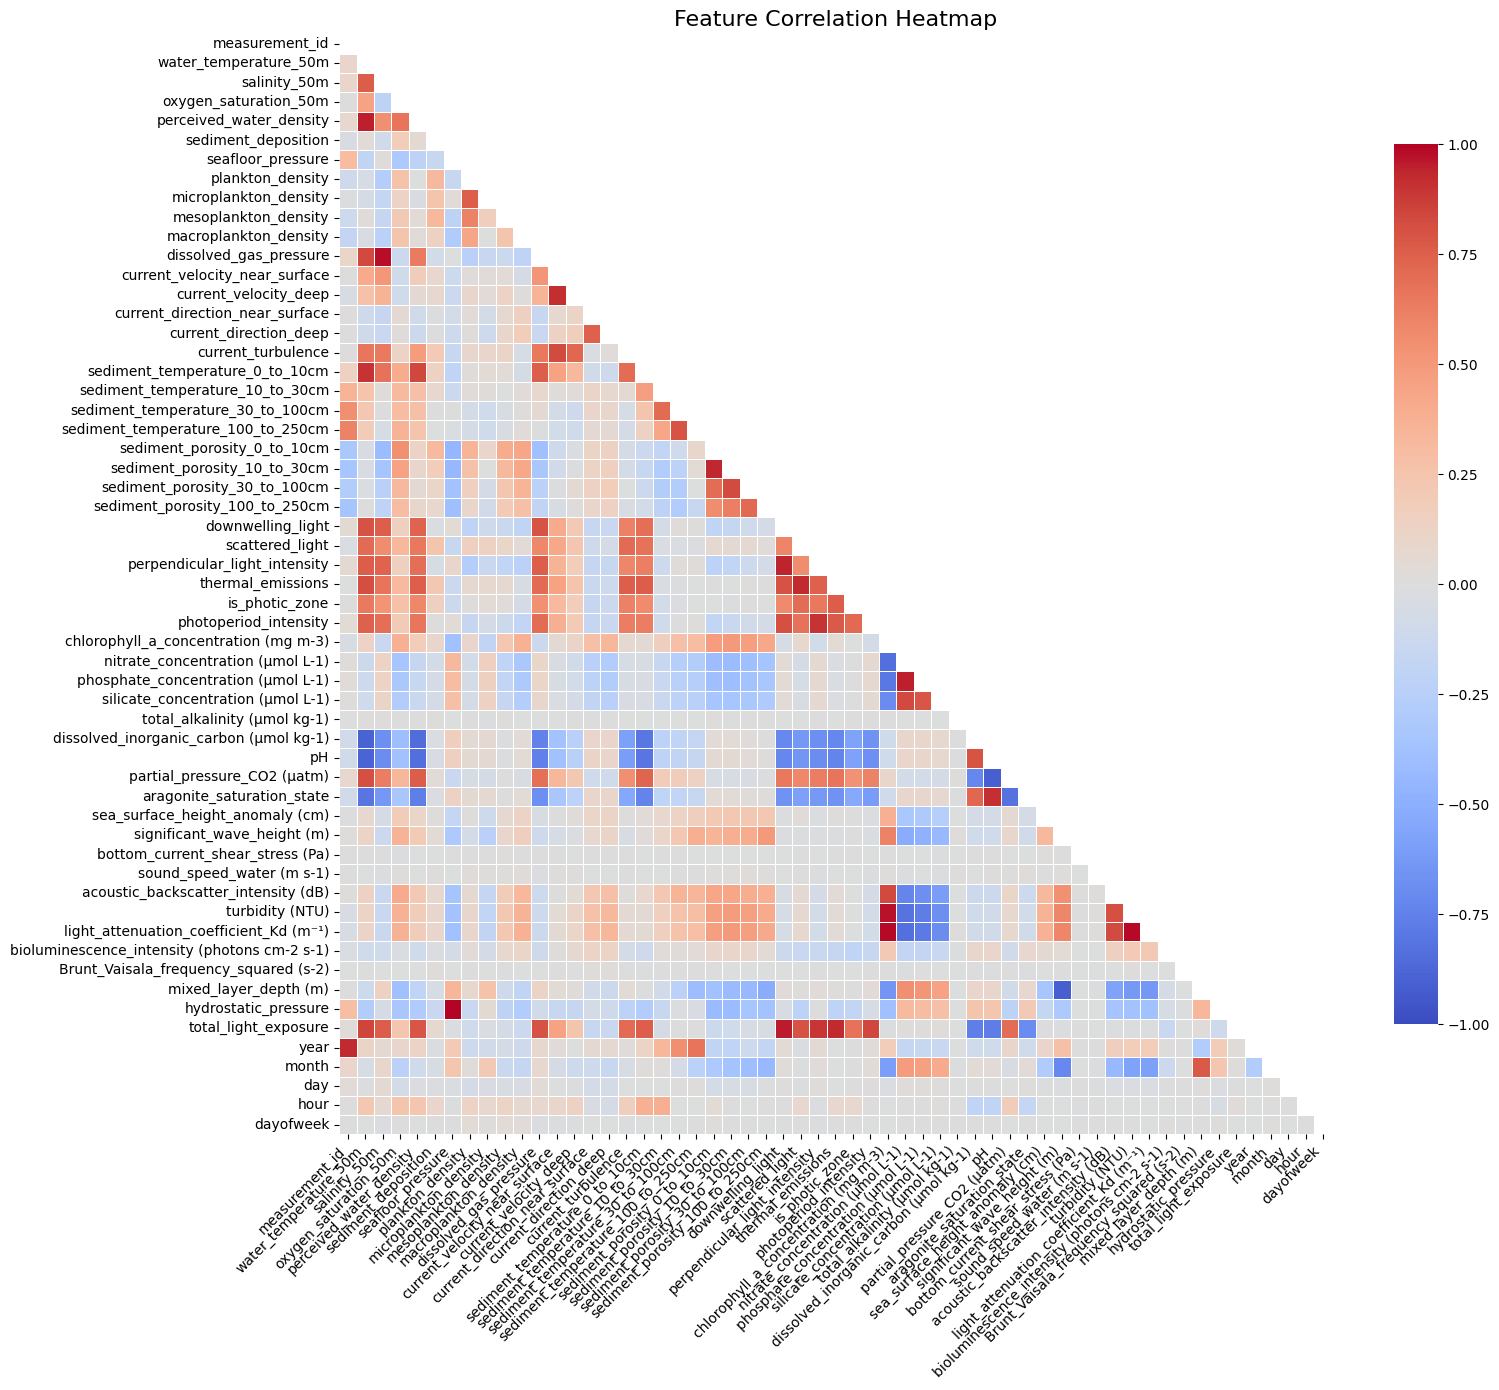

In [4]:
plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', 
            vmin=-1, vmax=1, linewidths=.5, cbar_kws={"shrink": .8})
plt.title('Feature Correlation Heatmap', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [5]:
# Calculate VIF for numeric columns
# First, drop NaN values
df_vif = df[numeric_cols].dropna()

# If there are too many columns, select a subset
if len(df_vif.columns) > 30:
    # Remove year, month, day, hour columns from VIF analysis as they're temporal
    vif_cols = [col for col in df_vif.columns if col not in ['year', 'month', 'day', 'hour', 'dayofweek', 'measurement_id']]
    
    # Take columns with fewer NaN values (most complete data)
    vif_cols = sorted(vif_cols, key=lambda col: df[col].isna().sum())[:25]
    df_vif = df[vif_cols].dropna()

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["feature"] = df_vif.columns
vif_data["VIF"] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]

# Sort by VIF and display
vif_data = vif_data.sort_values("VIF", ascending=False)
print("Variance Inflation Factors (VIF):")
print(vif_data)

# Identify features with high multicollinearity (VIF > 10)
high_vif = vif_data[vif_data["VIF"] > 10]
print("\nFeatures with high multicollinearity (VIF > 10):")
print(high_vif)

Variance Inflation Factors (VIF):
                                  feature           VIF
11       sediment_temperature_30_to_100cm  1.251784e+06
23      sediment_temperature_100_to_250cm  8.998776e+05
19        sediment_temperature_10_to_30cm  2.720006e+05
17              sound_speed_water (m s-1)  2.341477e+04
10           total_alkalinity (µmol kg-1)  1.092869e+04
6                    total_light_exposure  3.765076e+03
0                       downwelling_light  1.868336e+03
1                         scattered_light  5.050528e+02
9                 perceived_water_density  4.429619e+02
18    acoustic_backscatter_intensity (dB)  3.623174e+02
20         sediment_porosity_100_to_250cm  1.260953e+02
14       nitrate_concentration (µmol L-1)  1.017224e+02
12                        turbidity (NTU)  6.629200e+01
7    chlorophyll_a_concentration (mg m-3)  5.649024e+01
3                       thermal_emissions  5.174690e+01
2           perpendicular_light_intensity  4.135497e+01
24            

In [6]:
features_porosity = [
'sediment_porosity_0_to_10cm',
'sediment_porosity_10_to_30cm',
'sediment_porosity_30_to_100cm',
'sediment_porosity_100_to_250cm'
]

In [7]:
# Pastikan kolom-kolom ini ada di DataFrame
missing_cols = [col for col in features_porosity if col not in df.columns]
if missing_cols:
    print(f"Kolom berikut tidak ditemukan di DataFrame dan akan dilewati: {missing_cols}")
    features_porosity = [col for col in features_porosity if col in df.columns]

if not features_porosity:
    print("Tidak ada fitur porositas yang valid untuk diimputasi.")
else:
    # Buat subset DataFrame hanya dengan fitur yang akan diimputasi
    # dan simpan indeks aslinya
    df_subset_porosity = df[features_porosity].copy()
    original_index_porosity = df_subset_porosity.index

    # Simpan kondisi NaN awal untuk perbandingan
    nan_mask_porosity_original = df_subset_porosity.isnull()

    print("Missing values SEBELUM imputasi KNN (fitur porositas):")
    print(df_subset_porosity.isnull().sum().loc[lambda x: x > 0])
    print("-" * 30)

    # Hanya lanjutkan jika ada missing values
    if df_subset_porosity.isnull().any().any():
        # 1. Scaling
        # Karena KNN sensitif terhadap skala, scaling penting.
        scaler_porosity = StandardScaler()
        # Simpan nama kolom sebelum scaling
        scaled_columns_porosity = df_subset_porosity.columns
        df_scaled_porosity_array = scaler_porosity.fit_transform(df_subset_porosity)
        df_scaled_porosity = pd.DataFrame(df_scaled_porosity_array, columns=scaled_columns_porosity, index=original_index_porosity)

        # 2. Imputasi menggunakan KNNImputer
        # n_neighbors=3 atau 5 adalah nilai awal yang baik.
        # Pastikan n_neighbors tidak lebih besar dari jumlah sampel non-NaN yang tersedia.
        # Jika jumlah baris sangat sedikit, kurangi n_neighbors.
        n_samples = len(df_scaled_porosity)
        k_neighbors = min(3, n_samples - 1 if n_samples > 1 else 1)

        imputer_porosity = KNNImputer(n_neighbors=k_neighbors)

        # Imputer akan mengembalikan numpy array
        df_imputed_scaled_porosity_array = imputer_porosity.fit_transform(df_scaled_porosity)

        # Konversi kembali ke DataFrame
        df_imputed_scaled_porosity = pd.DataFrame(df_imputed_scaled_porosity_array, columns=scaled_columns_porosity, index=original_index_porosity)

        # 3. Kembalikan ke skala semula (inverse transform)
        df_imputed_original_scale_porosity_array = scaler_porosity.inverse_transform(df_imputed_scaled_porosity)
        df_imputed_original_scale_porosity = pd.DataFrame(df_imputed_original_scale_porosity_array, columns=scaled_columns_porosity, index=original_index_porosity)

        # 4. Gabungkan kembali nilai yang sudah diimputasi ke DataFrame df utama
        for col in features_porosity:
            df.loc[original_index_porosity, col] = df_imputed_original_scale_porosity[col]

        print("\nMissing values SETELAH imputasi KNN (fitur porositas):")
        print(df[features_porosity].isnull().sum().loc[lambda x: x > 0]) # Harusnya kosong jika semua terimputasi
        print("-" * 30)

        # --- TAMPILKAN PERBANDINGAN ---
        print("Perbandingan SEBELUM dan SESUDAH imputasi KNN (hanya nilai yang diimputasi pada fitur porositas):")
        any_imputed_porosity = False
        for feature in features_porosity:
            # Dapatkan indeks dari df_subset_porosity (original_index_porosity) di mana fitur ini awalnya NaN
            idx_nan_in_feature_porosity = nan_mask_porosity_original[nan_mask_porosity_original[feature]].index

            if not idx_nan_in_feature_porosity.empty:
                any_imputed_porosity = True
                print(f"\n--- Fitur: {feature} ---")
                # Nilai sebelum diambil dari salinan yang kita buat (df_subset_porosity sebelum modifikasi inplace)
                # atau lebih baik, dari df_subset_porosity yang dibuat di awal
                before_values = df_subset_porosity.loc[idx_nan_in_feature_porosity, feature]
                # Nilai sesudah diambil dari df utama yang sudah diupdate
                after_values = df.loc[idx_nan_in_feature_porosity, feature]

                comparison_df_porosity = pd.DataFrame({
                    'Indeks Asli': idx_nan_in_feature_porosity, # Untuk referensi ke baris asli
                    'Sebelum': before_values,
                    'Sesudah': after_values.round(4) # Pembulatan untuk tampilan
                }).set_index('Indeks Asli')
                print(comparison_df_porosity)
        if not any_imputed_porosity:
            print("Tidak ada nilai spesifik yang teridentifikasi telah diimputasi (mungkin tidak ada NaN awal pada fitur porositas).")

    else:
        print("Tidak ada missing values pada fitur porositas untuk diimputasi.")

Missing values SEBELUM imputasi KNN (fitur porositas):
sediment_porosity_0_to_10cm       3853
sediment_porosity_10_to_30cm      3914
sediment_porosity_30_to_100cm     5612
sediment_porosity_100_to_250cm    3260
dtype: int64
------------------------------

Missing values SETELAH imputasi KNN (fitur porositas):
Series([], dtype: int64)
------------------------------
Perbandingan SEBELUM dan SESUDAH imputasi KNN (hanya nilai yang diimputasi pada fitur porositas):

--- Fitur: sediment_porosity_0_to_10cm ---
             Sebelum  Sesudah
Indeks Asli                  
6                NaN   0.2890
14               NaN   0.2583
18               NaN   0.3307
21               NaN   0.2743
28               NaN   0.2737
...              ...      ...
21872            NaN   0.1840
21873            NaN   0.1807
21875            NaN   0.2197
21877            NaN   0.1040
21886            NaN   0.1923

[3853 rows x 2 columns]

--- Fitur: sediment_porosity_10_to_30cm ---
             Sebelum  Sesudah
I

In [8]:
print("\nDataFrame df setelah imputasi fitur porositas (cuplikan):")
print(df[features_porosity + ['hour']].head(10).to_string())


DataFrame df setelah imputasi fitur porositas (cuplikan):
   sediment_porosity_0_to_10cm  sediment_porosity_10_to_30cm  sediment_porosity_30_to_100cm  sediment_porosity_100_to_250cm  hour
0                        0.272                      0.272333                       0.269000                        0.323000     0
1                        0.271                      0.278000                       0.269000                        0.323667     1
2                        0.271                      0.278000                       0.269000                        0.323667     2
3                        0.270                      0.272000                       0.268000                        0.323000     3
4                        0.270                      0.272667                       0.259667                        0.323000     4
5                        0.269                      0.277000                       0.268000                        0.323000     5
6                        0.289 

In [9]:
df.to_csv('data/fitur_clean/porosity.csv', index=False)